# YOLO v3

Basado en: https://github.com/patrick013/Object-Detection---Yolov3/blob/master/Object_Detection_Yolo.ipynb

Interesante: https://towardsdatascience.com/object-detection-part2-6a265827efe1

In [ ]:
import struct
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model
from keras.utils import load_img
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims

In [ ]:
!wget https://www.puentescalvo.com/DATA/yolov3/yolov3.h5   -O yolo.h5
!wget https://www.puentescalvo.com/DATA/yolov3/classes.txt -O classes.txt
!wget https://www.puentescalvo.com/DATA/yolov3/anchors.txt -O anchors.txt


--2023-08-16 18:02:54--  https://www.puentescalvo.com/DATA/yolov3/yolov3.h5
Resolving www.puentescalvo.com (www.puentescalvo.com)... 208.97.181.72
Connecting to www.puentescalvo.com (www.puentescalvo.com)|208.97.181.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248671752 (237M)
Saving to: ‘yolo.h5’

yolo.h5             100%[===================>] 237.15M  60.4MB/s    in 4.2s    

2023-08-16 18:02:58 (56.4 MB/s) - ‘yolo.h5’ saved [248671752/248671752]

--2023-08-16 18:02:58--  https://www.puentescalvo.com/DATA/yolov3/classes.txt
Resolving www.puentescalvo.com (www.puentescalvo.com)... 208.97.181.72
Connecting to www.puentescalvo.com (www.puentescalvo.com)|208.97.181.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]     625  --.-KB/s    in 0s      

2023-08-16 18:02:59 (427 MB/s) - ‘classes.txt’ saved [625/625]

--2023-08-16 18:02:59--  https:

In [ ]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

len(labels)

80

In [ ]:
from keras.models import load_model

# Carga del modelo
model = load_model("yolo.h5")

# Clases
with open("classes.txt") as f:
    class_names = f.readlines()
labels = [c.strip() for c in class_names]

# Anchors
with open("anchors.txt") as f:
    anchors = f.readline()
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)

model.compile()

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_0 (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, None, None,   128         ['conv_0[0][0]']                 
                                32)                                                           

In [ ]:
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving calle.jpeg to calle.jpeg


In [ ]:
IMAGE_WIDTH=416
IMAGE_HEIGHT=416
def load_and_preprocess_image(path,shape):
  image=tf.io.read_file(path)
  width,height=load_img(path).size
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image, shape)
  image/=255
  return image,width,height

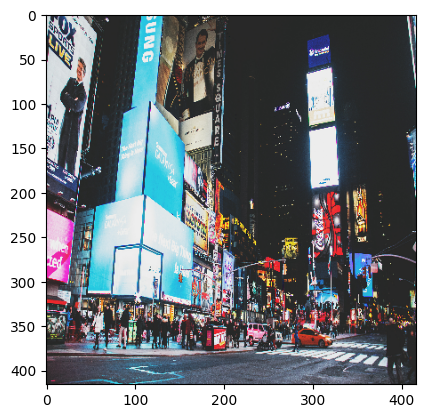

In [ ]:
_image, image_w, image_h=load_and_preprocess_image(filename,[IMAGE_WIDTH,IMAGE_HEIGHT])

plt.imshow(_image)


In [ ]:
image = expand_dims(_image, 0)
yhat = model.predict(image)
print([a.shape for a in yhat])


1/1 [==============================] - 0s 29ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [ ]:
# This cell is based on https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
class BoundBox:
	'''
	Objects of boxes. (xmin,ymin) represents the upleft coordinate of the box while (xmax,ymax) means downright one.
	'''
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			# if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

for i in range(len(boxes)):
	x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
	y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
	boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
	boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
	boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
	boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
len(boxes)


10647

In [ ]:
def box_filter(boxes,labels,threshold_socre):
	valid_boxes=[]
	valid_labels=[]
	valid_scores=[]
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > threshold_socre:
				valid_boxes.append(box)
				valid_labels.append(labels[i])
				valid_scores.append(box.classes[i])

	return (valid_boxes,valid_labels,valid_scores)

In [ ]:
valid_data= box_filter(boxes, labels, threshold_socre=0.6)


In [ ]:
def draw_boxes(filename, valid_data):
	data = pyplot.imread(filename)
	pyplot.imshow(data)
	ax = pyplot.gca()
	for i in range(len(valid_data[0])):
		box = valid_data[0][i]
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		ax.add_patch(rect)
		print(valid_data[1][i], valid_data[2][i])
		label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
		pyplot.text(x1, y1, label, color='white')
	pyplot.show()


person 0.9468469
person 0.82508457
person 0.8150275
person 0.7731989
person 0.6798215
person 0.7299933
person 0.9348537
person 0.75516045
person 0.7737121
person 0.84327567
car 0.9184442
person 0.6225772
car 0.7890088
person 0.651748
person 0.86032283
car 0.61829174
car 0.9869915


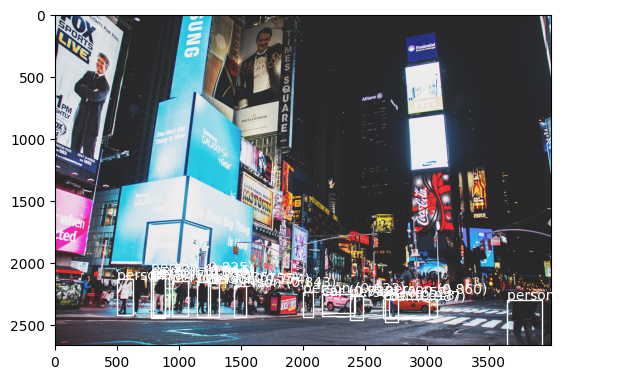

In [ ]:
draw_boxes(filename,valid_data)


In [ ]:
def encoder_dic(valid_data):
  data_dic={}
  (valid_boxes,valid_labels,valid_scores)=valid_data
  for box, label,score in zip(valid_boxes,valid_labels,valid_scores):
    if label not in data_dic:
      data_dic[label]=[[score,box,'kept']]
    else:
      data_dic[label].append([score,box,'kept'])
  return data_dic

dic=encoder_dic(valid_data)


In [ ]:
def decode_box_coor(box):
  return (box.xmin, box.ymin,box.xmax, box.ymax )

def iou(box1, box2):
  (box1_x1, box1_y1, box1_x2, box1_y2) = decode_box_coor(box1)
  (box2_x1, box2_y1, box2_x2, box2_y2) = decode_box_coor(box2)

  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-inter_area

  iou = inter_area/union_area

  return iou

def do_nms(data_dic, nms_thresh):
  final_boxes,final_scores,final_labels=list(),list(),list()
  for label in data_dic:
    scores_boxes=sorted(data_dic[label],reverse=True)
    for i in range(len(scores_boxes)):
      if scores_boxes[i][2]=='removed': continue
      for j in range(i+1,len(scores_boxes)):
        if iou(scores_boxes[i][1],scores_boxes[j][1]) >= nms_thresh:
          scores_boxes[j][2]="removed"

    for e in scores_boxes:
      print(label+' '+str(e[0]) + " status: "+ e[2])
      if e[2]=='kept':
        final_boxes.append(e[1])
        final_labels.append(label)
        final_scores.append(e[0])


  return (final_boxes,final_labels,final_scores)

In [ ]:
final_data=do_nms(dic, 0.9)


person 0.9468469 status: kept
person 0.9348537 status: kept
person 0.86032283 status: kept
person 0.84327567 status: kept
person 0.82508457 status: kept
person 0.8150275 status: kept
person 0.7737121 status: kept
person 0.7731989 status: kept
person 0.75516045 status: kept
person 0.7299933 status: kept
person 0.6798215 status: kept
person 0.651748 status: kept
person 0.6225772 status: kept
car 0.9869915 status: kept
car 0.9184442 status: kept
car 0.7890088 status: kept
car 0.61829174 status: kept


person 0.9468469
person 0.9348537
person 0.86032283
person 0.84327567
person 0.82508457
person 0.8150275
person 0.7737121
person 0.7731989
person 0.75516045
person 0.7299933
person 0.6798215
person 0.651748
person 0.6225772
car 0.9869915
car 0.9184442
car 0.7890088
car 0.61829174


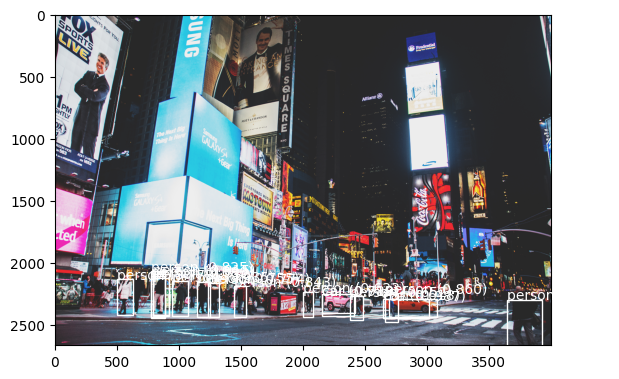

In [ ]:
draw_boxes(filename,final_data)
